# Simple neural network predicting ahead of time

Using [otexts](https://otexts.com/fpp2/nnetar.html) as a reference.

requires tensorflow environment

In [131]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist

#pkerastting
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [7]:
#import data
basic_rates_path = '../merged_data/resampled_tudf_minute_basic.csv'
rdf = pd.read_csv(basic_rates_path)

In [6]:
rdf

,created_at,tweet_rate_60,tweet_rate_600,time_since_last_tweet_rolling_60,time_since_last_tweet_rolling_600
0,2022-04-29 19:46:00+00:00,NaN,NaN,NaN,NaN
1,2022-04-29 19:47:00+00:00,NaN,NaN,NaN,NaN
2,2022-04-29 19:48:00+00:00,NaN,NaN,NaN,NaN
3,2022-04-29 19:49:00+00:00,NaN,NaN,NaN,NaN
4,2022-04-29 19:50:00+00:00,0.275387,NaN,3.633333,NaN
...,...,...,...,...,...
8769,2022-05-05 21:55:00+00:00,0.688653,0.655620,1.453333,1.525292
8770,2022-05-05 21:56:00+00:00,0.665937,0.649971,1.504687,1.538542
8771,2022-05-05 21:57:00+00:00,0.573858,0.643458,1.744298,1.554123
8772,2022-05-05 21:58:00+00:00,0.645358,0.639689,1.558865,1.563298


Create a new dataframe of lagged values to input in the NN.

Pick a point in time, then get the last T minutes. These could also be spaced at S skipped intervals. This data will be highly redundant, but prepared ahead of time.

In [111]:
# for each entry in tweet_rate_60,

# create a row in a dataframe with that value and T previous values

number_previous_values = 20  #20 minutes before

tweet_rate_df = pd.DataFrame([rdf['tweet_rate_60'][:5000]]*(number_previous_values+1)).T
tweet_rate_df.dropna(inplace = True)
tweet_rate_df.columns = range(len(tweet_rate_df.columns))
tweet_rate_df.index = rdf['created_at'][:4996]
tweet_rate_df


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 19:46:00+00:00,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,...,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387,0.275387
2022-04-29 19:47:00+00:00,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,...,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223,0.293223
2022-04-29 19:48:00+00:00,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,...,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841,0.285841
2022-04-29 19:49:00+00:00,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,...,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971,0.334971
2022-04-29 19:50:00+00:00,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,...,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 06:57:00+00:00,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,...,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737,0.770737
2022-05-03 06:58:00+00:00,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,...,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661,1.072661
2022-05-03 06:59:00+00:00,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,...,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928,1.066928


In [112]:
#shift columns
for column in tweet_rate_df.columns:
    tweet_rate_df[column] = tweet_rate_df[column].shift(column)
tweet_rate_df.dropna(inplace = True)
tweet_rate_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-29 20:06:00+00:00,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,0.388040,...,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223,0.275387
2022-04-29 20:07:00+00:00,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,0.415126,...,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841,0.293223
2022-04-29 20:08:00+00:00,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,0.419436,...,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971,0.285841
2022-04-29 20:09:00+00:00,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,0.354769,...,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282,0.334971
2022-04-29 20:10:00+00:00,0.385661,0.397581,0.391300,0.376181,0.383798,0.438326,0.419237,0.339178,0.292630,0.319642,...,0.419436,0.415126,0.388040,0.341047,0.374363,0.359368,0.350328,0.364023,0.399959,0.403282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03 06:57:00+00:00,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,0.755772,...,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092,1.037286
2022-05-03 06:58:00+00:00,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,0.775613,...,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159,1.078092
2022-05-03 06:59:00+00:00,1.066928,1.072661,0.770737,0.784215,0.706482,0.800175,0.762062,0.807633,0.826228,0.793047,...,0.755772,0.785415,0.689459,0.704008,0.728153,0.813495,1.019475,0.829359,0.800096,0.809159


Each column is now a tweet rate (0) or the rate at the `column` minutes before.

In [113]:
#set up train-test-split.
# no stratify needed. These are numbos.
X_train, X_test, y_train, y_test = train_test_split(tweet_rate_df[range(1,20)],tweet_rate_df[0], train_size=0.8, shuffle = False)

In [114]:
#instantiate keras model
model = Sequential()

#add normal layers
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model.add(
    Dense(number_previous_values, activation = 'relu')
)
model.add(
    Dense(number_previous_values, activation = 'relu')
)
#no activation for output
model.add(
    Dense(1)
)

model.compile(
    loss = 'mean_squared_error',
    optimizer = 'adam'
)

In [115]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   batch_size = 256,
                    epochs = 2000
                   )

Epoch 1/2000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 0s 12ms/step - loss: 0.1239 - val_loss: 0.0283
Epoch 2/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0284
Epoch 3/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0170 - val_loss: 0.0254
Epoch 4/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0227
Epoch 5/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0219
Epoch 6

16/16 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0088
Epoch 76/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 77/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 78/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 79/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 80/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 81/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 82/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 83/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 84/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0086
Epoc

16/16 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 156/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0085
Epoch 157/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0087
Epoch 158/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0085
Epoch 159/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 160/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 161/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 162/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 163/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0085
Epoch 164/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.

16/16 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 236/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 237/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 238/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 239/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 240/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 241/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 242/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0088
Epoch 243/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 244/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.

16/16 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 316/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 317/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 318/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 319/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 320/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 321/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 322/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 323/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 324/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.

16/16 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0090
Epoch 396/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 397/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0089
Epoch 398/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0091
Epoch 399/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0088
Epoch 400/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 401/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0089
Epoch 402/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 403/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 404/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 476/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 477/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 478/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0089
Epoch 479/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 480/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 481/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 482/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 483/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 484/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 556/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 557/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 558/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 559/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 560/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 561/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 562/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 563/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 564/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 636/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 637/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 638/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 639/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 640/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 641/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 642/2000
16/16 [==============================] - ETA: 0s - loss: 0.004 - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 643/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 644/2000
16/16 [==============================] - 0s 2ms/step - los

16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 716/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0091
Epoch 717/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 718/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 719/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0091
Epoch 720/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0092
Epoch 721/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0091
Epoch 722/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 723/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0091
Epoch 724/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0098
Epoch 796/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 797/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 798/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 799/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0097
Epoch 800/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 801/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0093
Epoch 802/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 803/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0091
Epoch 804/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0092
Epoch 876/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0094
Epoch 877/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 878/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 879/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 880/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 881/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0094
Epoch 882/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0093
Epoch 883/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0093
Epoch 884/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.

16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 956/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0093
Epoch 957/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 958/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 959/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 960/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 961/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 962/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 963/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0094
Epoch 964/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.

Epoch 1035/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1036/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 1037/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1038/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1039/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0098
Epoch 1040/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1041/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1042/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0096
Epoch 1043/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 1044/2000
16/16 [==============================] - 0s 3ms/step - lo

16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1115/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 1116/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1117/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 1118/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1119/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 1120/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1121/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 1122/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 1123/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1194/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 1195/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 1196/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1197/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0101
Epoch 1198/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0096
Epoch 1199/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 1200/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1201/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 1202/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0099
Epoch 1273/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1274/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1275/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1276/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 1277/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1278/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 1279/2000
16/16 [==============================] - ETA: 0s - loss: 0.005 - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1280/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1281/2000
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0104
Epoch 1352/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 1353/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 1354/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 1355/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0095
Epoch 1356/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 1357/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1358/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1359/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1360/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1431/2000
16/16 [==============================] - ETA: 0s - loss: 0.004 - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1432/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0098
Epoch 1433/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1434/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1435/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 1436/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1437/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1438/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1439/2000
16/16 [==============================] - 0s 3ms/s

16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1510/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1511/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1512/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1513/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1514/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1515/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0106
Epoch 1516/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1517/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 1518/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1589/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1590/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1591/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 1592/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 1593/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1594/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1595/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1596/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1597/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 1668/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 1669/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 1670/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1671/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 1672/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0104
Epoch 1673/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1674/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1675/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 1676/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1747/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1748/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 1749/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1750/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1751/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0100
Epoch 1752/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1753/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 1754/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1755/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1826/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1827/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1828/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1829/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 1830/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1831/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 1832/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0102
Epoch 1833/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0108
Epoch 1834/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0052 - val

16/16 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1905/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1906/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1907/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 1908/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0100
Epoch 1909/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 1910/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1911/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 1912/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 1913/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val

16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 1984/2000
16/16 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0106
Epoch 1985/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1986/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0100
Epoch 1987/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 1988/2000
16/16 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0099
Epoch 1989/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 1990/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 1991/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 1992/2000
16/16 [==============================] - 0s 3ms/step - loss: 0.0050 - val

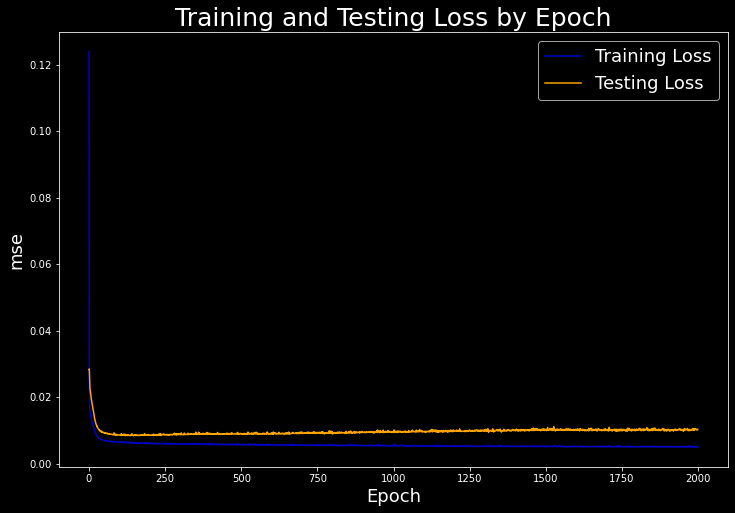

In [116]:
plt.style.use('dark_background')
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color=colors.to_rgba('b',0.8))
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('mse', fontsize = 18)

plt.legend(fontsize = 18);

In [117]:
model.predict(X_test).flatten()

array([0.7598219 , 0.7241607 , 0.6765174 , 0.8020255 , 0.74786216,
       0.719037  , 0.61656487, 0.67119527, 0.7513302 , 0.68962824,
       0.7042813 , 0.67824316, 0.7037946 , 0.7614577 , 0.7401081 ,
       0.73342526, 0.85894036, 0.7001313 , 0.79807276, 0.76759446,
       0.7557104 , 0.91177464, 0.76875496, 0.8148587 , 0.82865167,
       0.82407844, 0.7372851 , 0.806472  , 0.7829907 , 0.72271734,
       0.7098515 , 0.7614976 , 1.3837856 , 1.6323918 , 1.7622415 ,
       1.5916604 , 1.8905036 , 2.2172391 , 2.383856  , 2.241671  ,
       1.6281545 , 1.7605406 , 1.624457  , 1.685488  , 1.9338824 ,
       1.8305482 , 1.6612594 , 1.5915934 , 1.4564296 , 1.5737427 ,
       1.3591399 , 1.4588786 , 1.56659   , 1.3049121 , 1.2884296 ,
       1.3761834 , 1.4199748 , 1.331754  , 1.2380162 , 1.3628052 ,
       1.2558398 , 1.0661138 , 1.1855589 , 1.2181002 , 1.1895317 ,
       1.028237  , 1.1826388 , 1.2406075 , 1.1353658 , 1.0079272 ,
       1.088574  , 1.1854726 , 1.0209358 , 1.1356465 , 1.18866

In [118]:
results = list(model.predict(X_test).flatten())

In [119]:
len(_)

996

In [120]:
results

[0.7598219,
 0.7241607,
 0.6765174,
 0.8020255,
 0.74786216,
 0.719037,
 0.61656487,
 0.67119527,
 0.7513302,
 0.68962824,
 0.7042813,
 0.67824316,
 0.7037946,
 0.7614577,
 0.7401081,
 0.73342526,
 0.85894036,
 0.7001313,
 0.79807276,
 0.76759446,
 0.7557104,
 0.91177464,
 0.76875496,
 0.8148587,
 0.82865167,
 0.82407844,
 0.7372851,
 0.806472,
 0.7829907,
 0.72271734,
 0.7098515,
 0.7614976,
 1.3837856,
 1.6323918,
 1.7622415,
 1.5916604,
 1.8905036,
 2.2172391,
 2.383856,
 2.241671,
 1.6281545,
 1.7605406,
 1.624457,
 1.685488,
 1.9338824,
 1.8305482,
 1.6612594,
 1.5915934,
 1.4564296,
 1.5737427,
 1.3591399,
 1.4588786,
 1.56659,
 1.3049121,
 1.2884296,
 1.3761834,
 1.4199748,
 1.331754,
 1.2380162,
 1.3628052,
 1.2558398,
 1.0661138,
 1.1855589,
 1.2181002,
 1.1895317,
 1.028237,
 1.1826388,
 1.2406075,
 1.1353658,
 1.0079272,
 1.088574,
 1.1854726,
 1.0209358,
 1.1356465,
 1.1886681,
 1.0917844,
 0.9631376,
 0.96770227,
 1.0817001,
 1.0009279,
 0.9448966,
 0.9213918,
 0.9354364,


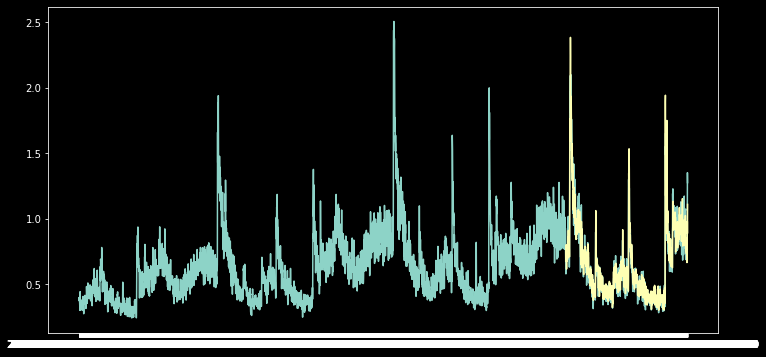

In [121]:
#first neural network results.
plt.figure(figsize=(12,6))
plt.plot(tweet_rate_df.index, tweet_rate_df[0])
plt.plot(tweet_rate_df.index[3980:5000], results)


Text(0.5, 1.0, 'Residuals for tweet rate on first neural network')

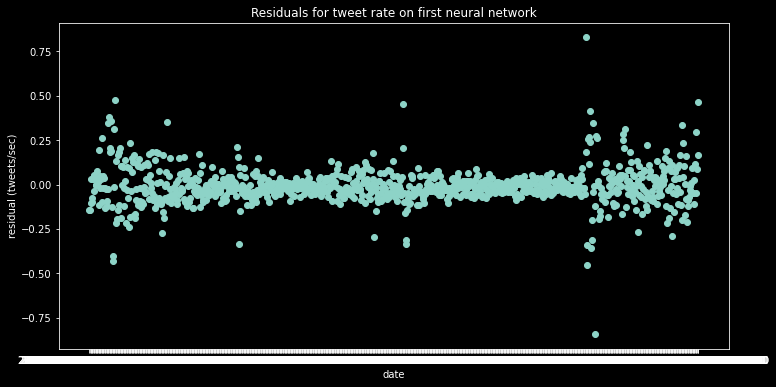

In [129]:
# look at residuals

plt.figure(figsize = (12,6))
plt.scatter(y_test.index, y_test - results)
plt.xlabel('date')
plt.ylabel('residual (tweets/sec)')
plt.title('Residuals for tweet rate on first neural network');

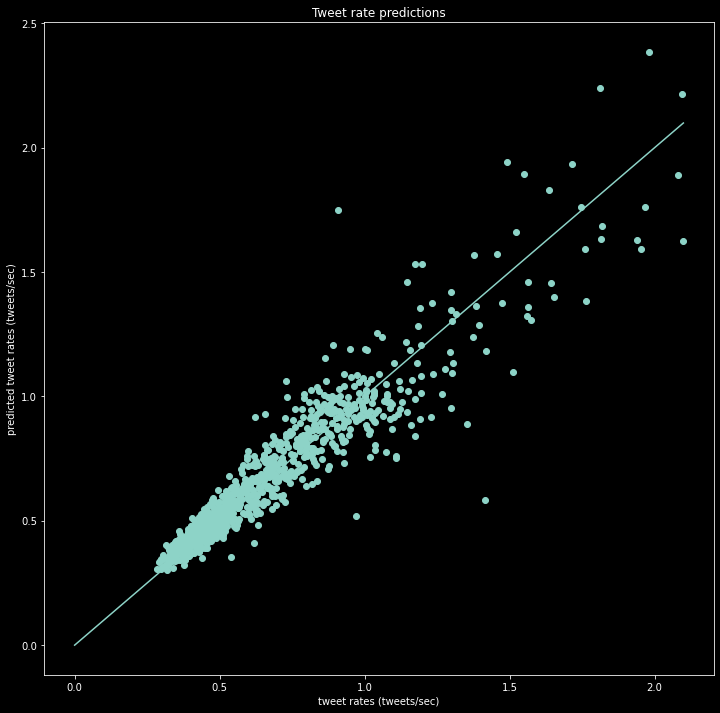

In [130]:
# look at predictions and true values

plt.figure(figsize = (12,12))
plt.scatter( y_test,  results)
plt.xlabel('tweet rates (tweets/sec)')
plt.ylabel('predicted tweet rates (tweets/sec)')
plt.plot([0, y_test.max()], [0,y_test.max()] )
plt.title('Tweet rate predictions');

In [145]:
# get r2 for these
y_test_2 = [ [thing] for thing in y_test]

lr = LinearRegression()
lr.fit(y_test_2, results)
lr.score(y_test_2, results)

0.8866115379563191

In [ ]:
# R2 of 0.89 for this!

In [146]:
residuals = y_test - results

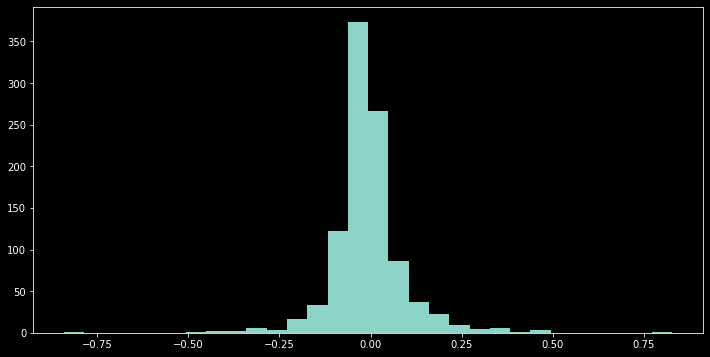

In [151]:
plt.figure(figsize = (12,6))
plt.hist( residuals, bins = 30);

In [152]:
np.std(residuals)

0.10114369780174802

In [153]:
np.mean(residuals)

-0.007593492314530135

The mean is well within the std.